# Plotting LLC curve experiments

In [250]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize

import json
import os
from datetime import datetime

import seaborn as sns
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

pd.set_option('display.max_columns', 500)


import gen_commands_expt_llc_curve as gen_commands

In [376]:
# EXPT_NAME = "dev_202404251702"
# EXPT_NAME = "l2reg_202404271131"

# EXPT_NAME = "l2reg_202404272342" # actually it is varylr
# EXPT_NAME = "l2reg_202404272343" # actually it is varybatch

# EXPT_NAME = "varylr_202404290016"
# EXPT_NAME = "varybatch_202404290015"
# EXPT_NAME = "varybatch_epsilon_realisable_202404291728"
# EXPT_NAME = "varylr_epsilon_realisable_202404291729"

# EXPT_NAME = "sgld_sweep_202404292231"

# EXPT_NAME = "varybatch_202404301039"
EXPT_NAME = "varylr_202404301039"

IMAGEDIR = f"./images/expt_llc_curve/{EXPT_NAME}"
DRYRUN = False
SUPTITLES = True
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9

os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


def extract_data(subdir):
    with open(os.path.join(subdir, 'run.json'), 'r') as f:
        run = json.load(f)

    with open(os.path.join(subdir, 'config.json'), 'r') as f:
        config = json.load(f)

    with open(os.path.join(subdir, 'info.json'), 'r') as f:
        info = json.load(f)
    subdir_id = int(os.path.basename(subdir))
    doc = {"config": config, "info": info}
    data = []
    for x in info:
        sgld_completed = (len(x.get('loss_trace', [])) == config.get('sgld_config', {}).get('num_steps'))

        extracted_info = {
            "_id": subdir_id,
            "status": run.get('status'),
            "expt_name": config.get('expt_name'),
            "force_realisable": config.get('force_realisable'),
            "seed": config.get('seed'),
            "sgld_completed": sgld_completed,

            "t": x.get('t'),
            "lambdahat": x.get('lambdahat'),
            "loss_trace": x.get('loss_trace'),
            "init_loss": x.get('init_loss'),
            "test_accuracy": x.get('test_accuracy'),
            "train_accuracy": x.get('train_accuracy'),
            "train_loss": x.get('train_loss'),
        }
        for key, val in config.get('sgld_config', {}).items():
            extracted_info[f"sgld_config.{key}"] = val
        
        for key, val in config.get('training_config', {}).items():
            extracted_info[f"training_config.{key}"] = val
        
        for key in ["test_loss", "test_loss_no_reg"]: # backward compatibility purpose
            if key in x:
                extracted_info[key] = x[key]

        data.append(extracted_info)
    return data, doc

def extract_directory(directory_path):
    all_data = []

    for subdir in os.listdir(directory_path):
        full_subdir_path = os.path.join(directory_path, subdir)
        if subdir == "_sources" or not os.path.isdir(full_subdir_path):
            continue
        if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
            try: 
                data, doc = extract_data(full_subdir_path)
                all_data += data
                sample_doc = doc
            except Exception as e:
                print("ERROR: ", full_subdir_path)
                print(e)
    return all_data, sample_doc

def postprocess_df(df_data):
    df_data["first_nan_index"] = [
        list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
        for trace in df_data["loss_trace"]
    ]

    results = []
    results2 = []
    n = 50000 # TODO: hard coded CIFAR10 training data size
    for _, row in df_data.iterrows():
        losses = row["loss_trace"]
        init_loss = row["init_loss"]
        burn_in = int(BURN_IN_PROP * len(losses))
        lambdahat_burnin = (np.mean(losses[burn_in:]) - init_loss) * n / np.log(n)
        lambdahat_burnin_minibatch = (np.mean(losses[burn_in:]) - losses[0]) * n / np.log(n)
        results.append(lambdahat_burnin)
        results2.append(lambdahat_burnin_minibatch)
    df_data["lambdahat_with_burnin"] = results
    df_data["lambdahat_with_burnin_minibatch"] = results2
    return df_data


directory_path = f"./spartan_outputs/expt_llc_curve_outputs/{EXPT_NAME}"
all_data, sample_doc = extract_directory(directory_path)
df_data = pd.DataFrame(all_data)
print(df_data["sgld_completed"].value_counts())
print(df_data.groupby("_id").aggregate({"status": "unique"}).reset_index()["status"].value_counts())
df_data = df_data[df_data["status"] == "COMPLETED"]

df_data = postprocess_df(df_data)
df_data.head()

sgld_completed
True     225
False     54
Name: count, dtype: int64
status
[RUNNING]      18
[COMPLETED]     9
Name: count, dtype: int64


,_id,status,expt_name,force_realisable,seed,sgld_completed,t,lambdahat,loss_trace,init_loss,test_accuracy,train_accuracy,train_loss,sgld_config.batch_size,sgld_config.epsilon,sgld_config.gamma,sgld_config.num_chains,sgld_config.num_steps,training_config.batch_size,training_config.l2_regularization,training_config.learning_rate,training_config.momentum,training_config.num_steps,training_config.optim,test_loss,test_loss_no_reg,first_nan_index,lambdahat_with_burnin,lambdahat_with_burnin_minibatch
5,27,COMPLETED,varylr_202404301039,False,0,True,1.0,-323935.111240,"[20.06502342224121, 29.02041244506836, 8.37585...",72.098228,0.1000,0.10000,2.302585,2048,5.000000e-07,1.0,1,1500,512,None,0.2,NaN,30001,adam,72.379280,72.379280,NaN,-324308.360221,-83854.241548
6,27,COMPLETED,varylr_202404301039,False,0,True,1501.0,-3726.904710,"[1.9539237022399902, 1.9192184209823608, 1.797...",1.912930,0.4443,0.45920,1.030141,2048,5.000000e-07,1.0,1,1500,512,None,0.2,NaN,30001,adam,2.034752,2.034752,NaN,-4187.723027,-4377.162809
7,27,COMPLETED,varylr_202404301039,False,0,True,3001.0,-240.043896,"[0.5761072635650635, 0.6225194931030273, 0.595...",0.586807,0.6734,0.79822,0.558914,2048,5.000000e-07,1.0,1,1500,512,None,0.2,NaN,30001,adam,1.205267,1.205267,NaN,-335.801374,-286.354672
8,27,COMPLETED,varylr_202404301039,False,0,True,4501.0,-442.469990,"[0.40988045930862427, 0.375444233417511, 0.386...",0.404886,0.6780,0.86732,0.355244,2048,5.000000e-07,1.0,1,1500,512,None,0.2,NaN,30001,adam,1.445279,1.445279,NaN,-607.921931,-631.003917
9,27,COMPLETED,varylr_202404301039,False,0,True,6001.0,-364.207129,"[0.4012514054775238, 0.43507081270217896, 0.41...",0.413724,0.6757,0.88312,0.218714,2048,5.000000e-07,1.0,1,1500,512,None,0.2,NaN,30001,adam,2.009186,2.009186,NaN,-531.786798,-474.146631


In [377]:
# print out unique values for each config key
df = df_data
for key in sample_doc["config"].get("sgld_config", {}):
    print(f"sgld_config.{key:24s}: {df[f'sgld_config.{key}'].unique()}")

for key in sample_doc["config"].get("training_config", {}):
    print(f"training_config.{key:20s}: {df[f'training_config.{key}'].unique()}")

for key in ["force_realisable", "seed"]:
    print(f"{key:36s}: {df[key].unique()}")


sgld_config.batch_size              : [2048]
sgld_config.epsilon                 : [5.e-07 1.e-06]
sgld_config.gamma                   : [1.]
sgld_config.num_chains              : [1]
sgld_config.num_steps               : [1500]
training_config.batch_size          : [512]
training_config.l2_regularization   : [None]
training_config.learning_rate       : [0.2   0.01  0.1   0.005 0.05 ]
training_config.momentum            : [nan 0.9]
training_config.num_steps           : [30001]
training_config.optim               : ['adam' 'sgd']
force_realisable                    : [False]
seed                                : [0]


adam-None
(80, 29)
Saving file at: ./images/expt_llc_curve/varylr_202404301039/varylr_202404301039_adam-None_llc_curve.pdf


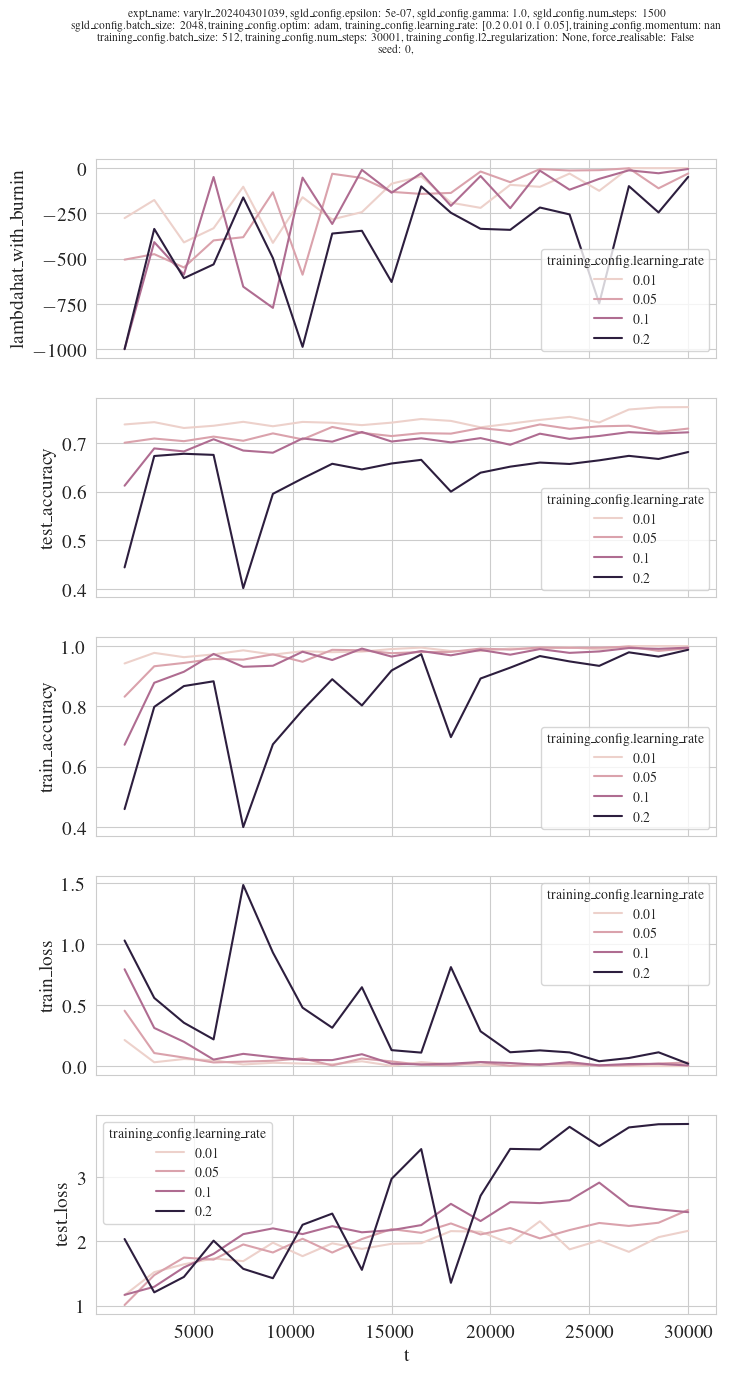

In [389]:

filters = {
    # "sgld_config.batch_size": 2048,
    "sgld_config.epsilon": 5e-7,
    # "training_config.batch_size": 512,
    # "training_config.l2_regularization": None,
    # "training_config.learning_rate": 0.001,
    # "training_config.momentum": 0.9,
    "training_config.optim": "adam",
    "force_realisable": False,
    # "seed": 0,
}
def _filter_df_data(df_data, filters):
    df = df_data.copy(deep=True)
    for key, val in filters.items():
        if val is None:
            df = df[df[key].isna()]
        else:
            df = df[df[key] == val]
    return df
df = _filter_df_data(df_data, filters)

optim_config = f"{filters['training_config.optim']}"
if "training_config.momentum" in filters and filters["training_config.momentum"] not in [None, 0.0] and not np.isnan(filters["training_config.momentum"]):
    optim_config += f"-{filters['training_config.momentum']}"
else:
    optim_config += "-None"
print(optim_config)


df = df[df["t"] > 1000]
yvar_name = "lambdahat_with_burnin"
df[yvar_name] = np.clip(df[yvar_name], -1e3, 1e4)
df = df[df["training_config.batch_size"] > 100]
print(df.shape)

# hue_var = "training_config.batch_size"
hue_var = "training_config.learning_rate"
# hue_var = "training_config.l2_regularization"
yvars = [
    "lambdahat_with_burnin", 
    # "lambdahat_with_burnin_minibatch",
    "test_accuracy",
    "train_accuracy",
    "train_loss",
    "test_loss",
    # "test_loss_no_reg"
]
fig, axes = plt.subplots(len(yvars), 1, figsize=(8, 3 * len(yvars)), sharex=True)
for ax, yvar_name in zip(axes, yvars):
    sns.lineplot(data=df, x="t", y=yvar_name, hue=hue_var, legend="full", ax=ax)

title_str = ""
line_break_counter = 0
entry_per_line = 4
if SUPTITLES:
    for key in gen_commands.config.keys():
        if key in df.columns:
            vals = df[key].unique()
            if len(vals) > 1:
                title_str += f"{key}: {vals}"
            else:
                title_str += f"{key}: {vals[0]}"
            line_break_counter += 1
            if line_break_counter % entry_per_line == 0:
                title_str += "\n"
            else:
                title_str += ", "
    fig.suptitle(title_str, fontsize="small")
savefig_fn(fig, f"{EXPT_NAME}_{optim_config}_llc_curve.pdf")

(1, 29)


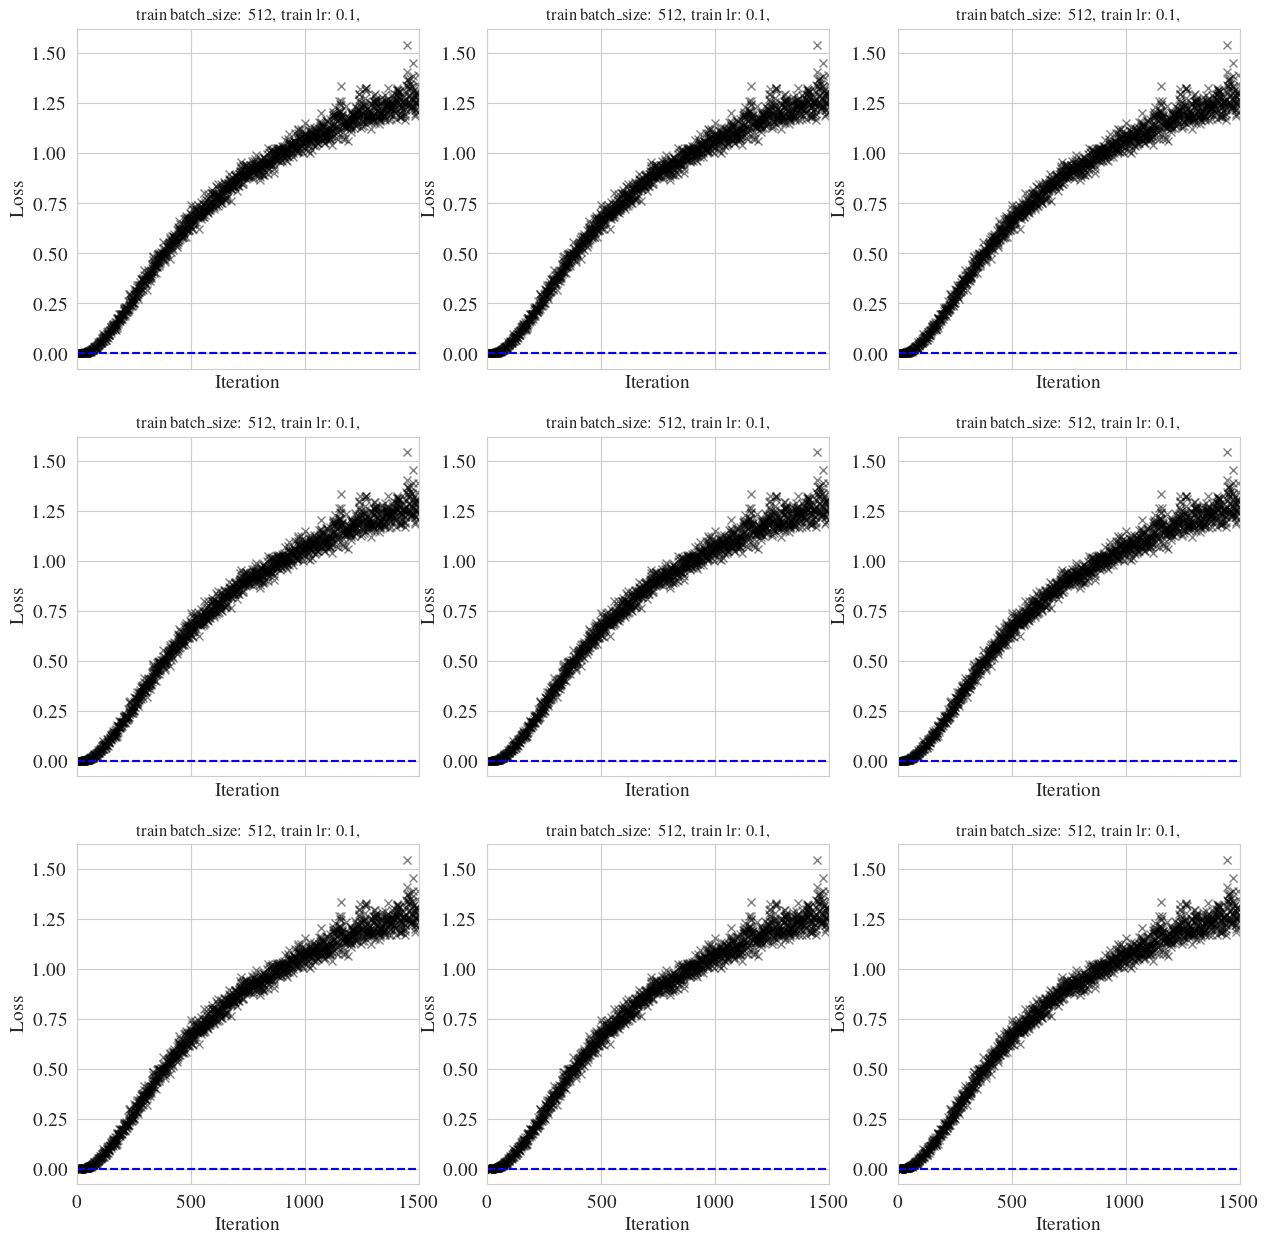

In [387]:

df = _filter_df_data(df_data, filters)
df = df[
    (df["t"] == df["t"].max())
    & (df["seed"] == df["seed"].max())
]
print(df.shape)
num_plots = 9
rand_ids = np.random.choice(df["_id"].unique(), num_plots)

num_cols = 3
num_rows = num_plots // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharex=True, sharey=False)
for idx, ax in zip(rand_ids, axes.flat):
    row = df[df["_id"] == idx]
    loss_trace = row["loss_trace"].iloc[0]
    ax.plot(loss_trace, "kx", alpha=0.5)
    ax.set_xlim(0, len(row["loss_trace"].iloc[0]))
    ax.set_title(
        f"train batch_size: {row['training_config.batch_size'].item()}, "
        f"train lr: {row['training_config.learning_rate'].item()}, "
    )
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    xmin, xmax = ax.get_xlim()
    ax.hlines(row["init_loss"].iloc[0], xmin, xmax, color="r", linestyle="--")
    ax.hlines(loss_trace[0], xmin, xmax, color="b", linestyle="--")

# ax.plot(df["loss_trace"].iloc[idx], "kx", alpha=0.5)
# xmin, xmax = ax.get_xlim()
# ax.hlines(df["init_loss"].iloc[idx], xmin, xmax, color="r", linestyle="--")


Text(0.5, 1.0, 'LLC vs Test Accuracy')

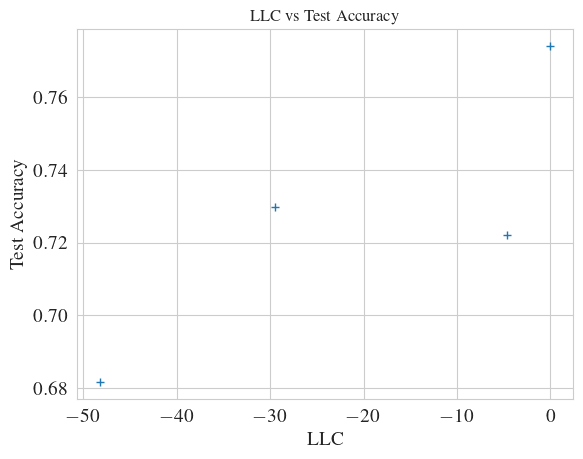

In [384]:
df = _filter_df_data(df_data, filters)
df = df[
    (df["t"] == df["t"].max())  # only take the last iteration
    # & (df["training_config.batch_size"] > 100)
    # & (df["lambdahat_with_burnin"] > 0)
]

fig, ax = plt.subplots()
ax.plot(df["lambdahat_with_burnin"], df["test_accuracy"], "+")
ax.set_xlabel("LLC")
ax.set_ylabel("Test Accuracy")
ax.set_title("LLC vs Test Accuracy")

In [347]:
import jax.numpy as jnp
x = jnp.array(np.random.randn(2, 3, 4))
jnp.linalg.norm(x.flatten(), ord=2)
jnp.linalg.sqnorm(x.flatten(), ord=2)

Array(4.964231, dtype=float32)